In [ ]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [1]:
# General imports
import os
import torch
import numpy as np
import pandas as pd
from copy import deepcopy 

# EUGENe imports and settings
from eugene import models
from eugene import train
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"

# EUGENe packages
import seqdata as sd
import motifdata as md

# Jores21CNN model filter activations

In [ ]:
import importlib
import logging
import os
from typing import Callable, Dict
import pandas as pd
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, key_word: str, index: int = None):
        super().__init__()
        print("here")
        self.model = model
        layers = sorted([k for k in dict([*model.named_modules()]) if key_word in k])
        self.features = {layer: torch.empty(0) for layer in layers}
        self.handles = dict()
        self.index = index

        for layerID in layers:
            layer = dict([*self.model.named_modules()])[layerID]
            handle = layer.register_forward_hook(self.SaveOutputHook(layerID, self.index))
            self.handles[layerID] = handle
            
    def SaveOutputHook(self, layerID: str, index: int = None) -> Callable:
        def fn(layer, input, output):
            if self.index is not None:
                self.features[layerID] = output[self.index]
            else:
                self.features[layerID] = output
        return fn

    def forward(self, x, **kwargs) -> Dict[str, torch.Tensor]:
        preds = self.model(x, **kwargs)
        return self.features, self.handles, preds

In [ ]:
layer_name = "arch.conv1d_tower.layers.1"

In [ ]:
test = FeatureExtractor(model, layer_name)

here


In [ ]:
sequences = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length").values[:128]
torch_seqs = torch.tensor(sequences, dtype=torch.float32).to("cuda")
torch_seqs.shape

torch.Size([128, 4, 170])

In [ ]:
test(torch_seqs)[0][layer_name][0].T

tensor([[1.5459e+01, 1.0637e+01, 8.3750e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.7454e+00, 8.9238e+00, 1.7021e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.3914e-01],
        [1.3599e+01, 6.6939e+00, 6.8417e+00,  ..., 0.0000e+00, 1.9704e-01,
         0.0000e+00],
        ...,
        [2.3480e+01, 8.1159e+00, 3.3599e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.4653e-02],
        [1.4490e+01, 1.3111e+01, 4.6861e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.4937e+01, 1.3624e+01, 4.5133e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [ ]:
import torch.nn.functional as F
def get_layer(
    model, 
    layer_name,
    index=None
):
    if index is not None:
        return dict([*model.named_modules()])[layer_name][index]
    else:
        return dict([*model.named_modules()])[layer_name]

In [ ]:
layer = get_layer(model, layer_name, index=0)
layer_outs = F.relu(F.conv1d(torch_seqs, layer)).detach().cpu().numpy()

# Filter viz padding fun!

In [ ]:
# Select the layer you want to interpret
layer_name = "arch.conv1d_tower.layers.0"

In [ ]:
from copy import deepcopy

# Grab motifs
core_promoter_elements = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
tf_clusters = md.read_meme(os.path.join(settings.dataset_dir, "TF-clusters.meme"))

# Smush them together, make function in the future
all_motifs = deepcopy(core_promoter_elements)
for motif in tf_clusters:
    all_motifs.add_motif(motif)
all_motifs

MotifSet with 78 motifs

In [ ]:
# Function for instantiating a new randomly initialized model
def prep_new_model(
    config,
    seed
):
    # Instantiate the model
    model = models.load_config(config_path=config, seed=seed)
    
    # Initialize the model prior to conv filter initialization
    models.init_weights(model, initializer="kaiming_normal")

    # Initialize the conv filters
    if model.arch_name == "Jores21CNN":
        layer_name = "arch.biconv.kernels"
        list_index = 0
    elif model.arch_name in ["CNN", "Hybrid", "DeepSTARR"]:
        layer_name = "arch.conv1d_tower.layers.0"
        list_index = None
    models.init_motif_weights(
        model=model,
        layer_name=layer_name,
        list_index=list_index,
        initializer="xavier_uniform",
        motifs=all_motifs,
        convert_to_pwm=False,
        divide_by_bg=True,
        motif_align="left",
        kernel_align="left"
    )

    # Return the model
    return model 

# Test the instantiation of each model to make sure this is working properly
model = prep_new_model("jores21_cnn.yaml", seed=0)

[rank: 0] Global seed set to 0


In [ ]:
# Biconv kernel
kernel = models.get_layer(model, "arch.biconv.kernels")[0]
bias = models.get_layer(model, "arch.biconv.biases")[0]
layer = torch.nn.Conv1d(
    in_channels=kernel.shape[1],
    out_channels=kernel.shape[0],
    kernel_size=kernel.shape[2],
    padding=3,
)
layer.weight = torch.nn.Parameter(kernel)
layer.bias = torch.nn.Parameter(bias)
layer.eval().to("cuda")

Conv1d(4, 256, kernel_size=(13,), stride=(1,), padding=(3,))

In [ ]:
# CNN kernel
layer = models.get_layer(model, layer_name)
layer.eval().to("cuda")

KeyError: 'arch.conv1d_tower.layers.0'

In [ ]:
layer.weight[0].T

tensor([[-0.0644,  0.9518, -0.0099,  0.8135],
        [ 0.0755,  1.0416,  0.2450,  0.3084],
        [ 0.3624,  0.7182,  0.2965,  0.2949],
        [-0.2303,  2.2587, -0.2260, -0.0779],
        [-0.6648, -0.4122, -0.5836,  3.3549],
        [ 3.1837, -0.5847, -0.5460, -0.4092],
        [-0.6230, -0.4994, -0.5484,  3.3169],
        [ 3.3471, -0.5894, -0.5655, -0.4997],
        [ 2.0172, -0.5185, -0.5487,  0.7171],
        [ 3.3724, -0.5445, -0.7431, -0.4344],
        [ 0.8061, -0.4995, -0.5303,  1.9385],
        [ 2.3005, -0.3084, -0.1780, -0.0385],
        [ 0.0620,  1.0483,  0.5805,  0.1094]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

In [ ]:
decode_seq(X_np[0])

'CTAAGCAGAGGAGCTAGCTAGGAAGAGGTACGGTGCTGGCTAAGCTAGCTAGATCCATCGTCCATGGAACTGAGAGCAGCAGCTACCTATATATCTAGCTGGTTTTCTAACGACGATGACGACGACCGCGGGACTAGCATGATGCAGCTAGCTGAACACAGTTGTAGGCA'

In [ ]:
decode_seq(X_np[0, :, 0:13])

'CTAAGCAGAGGAG'

In [ ]:
layer(X[0, :, 0:13])[0]

tensor([ 7.5600, 14.6840,  6.4640, 18.5880, 11.4820, 12.1840, 10.8380, 13.1880,
         8.6520,  9.5680,  7.4100,  3.4420,  6.5080], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
layer(X[0, :, 1:14])[0]

tensor([14.6840,  6.4560, 15.9680, 10.2700, 10.5900,  9.3320, 14.9160,  8.9780,
         9.6800,  7.4100,  3.4900,  6.5080,  2.2940], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
layer(X[0])[0]

tensor([ 7.5600, 14.6840,  6.4640, 18.5880, 11.4820, 12.1840, 10.8380, 14.9160,
         9.4800, 10.5960, 13.8400,  7.1320, 12.7080,  5.9900, 16.9140,  5.9520,
        18.7080,  9.2920, 16.9100, 10.1860, 24.0920, 12.8840, 12.5820, 11.3860,
        18.0620,  5.6800, 13.7600,  6.2300, 12.2140,  7.3760, 11.1300,  5.9040,
         6.9620, 11.4740,  6.1460,  8.2860, 13.2740,  8.2800, 17.6340, 11.6640,
        14.9380, 14.1280, 17.2320, 13.2040,  7.3620, 18.3040,  6.0500, 21.0440,
         9.3700, 19.7980,  7.5620, 22.0800,  6.7260, 19.2800,  7.7860, 15.0040,
         7.4400, 13.5440, 10.2840, 11.8900, 16.6680,  9.7600, 15.7660, 10.4240,
        19.8220, 13.7920, 18.7160, 12.9740, 11.0380, 14.6700, 13.7580, 11.7680,
        15.4880, 14.3840,  8.3820, 14.4780, 11.2420,  7.3300, 10.1800, 15.4800,
         6.5740, 13.4420,  9.3040, 16.6140,  5.9140, 24.3100,  8.1840, 22.3520,
        12.4620, 30.1020,  7.8100, 28.0560,  7.9560, 21.5620,  7.7540, 19.5920,
         4.4660, 16.0240,  6.7440, 11.90

In [ ]:
X_np = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length").to_numpy()
X = torch.tensor(X_np, dtype=torch.float32).to(device="cuda")
activations = F.relu(layer(X)).detach().cpu().numpy()

In [ ]:
from seqexplainer._utils import _k_largest_index_argsort
from seqexplainer.preprocess._preprocess import decode_seq, ohe_seq

In [ ]:
single_filter = activations[:, 0, :]
large_inds = _k_largest_index_argsort(single_filter, k=10)
single_filter.shape

(7595, 170)

In [ ]:
for ind in large_inds:
    print(ind)
    print(single_filter[ind[0], ind[1]])

[5817  121]
36.028
[4294  134]
36.028
[4576  125]
36.028
[6721  134]
36.028
[1005   26]
35.82
[1778  137]
35.812
[5739  137]
35.604
[1277  137]
35.566
[5395  120]
35.416
[4979  136]
35.416


In [ ]:
for i, seq in enumerate(X_np[large_inds[:, 0]]):
    print(i)
    start = large_inds[i, 1] - 6
    end = large_inds[i, 1] + 7
    print(decode_seq(seq)[start:end])

0
CCCCTATAAATAC
1
TCCCTATAAATAC
2
TCCCTATAAATAC
3
CCCCTATAAATAC
4
CCTCTATAAATAC
5
TCACTATAAATAC
6
CCGCTATAAATAC
7
TCCCTATAAATAG
8
CTCCTATAAATAC
9
TTCCTATAAATAC


In [ ]:
# Generate pfms from filters
interpret.generate_pfms_sdata(
    model,
    sdata,
    seq_key="ohe_seq",
    layer_name=layer_name,
    kernel_size=13,
    activations=activations,
    num_filters=1,
    padding=3,
    seqs=sdata["ohe_seq"].transpose("_sequence", "_ohe", "length").to_numpy(),
    num_seqlets=100
)

Using provided activations of shape (7595, 256, 164) and sequences of shape (7595, 4, 170).
updated 3 10


Getting filter activators for 1 filters:   0%|          | 0/1 [00:00<?, ?it/s]

Activators shape: (1, 100, 4, 13)


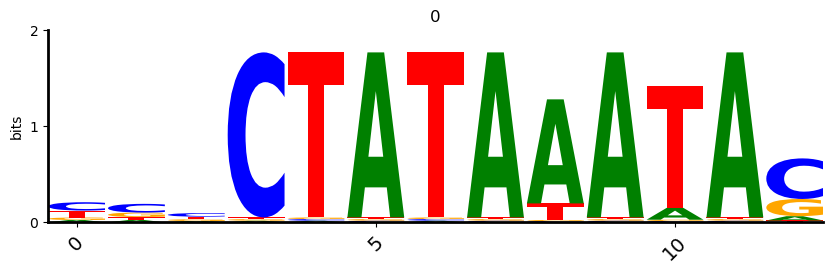

In [ ]:
# Visualize a filter of choice
pl.filter_viz(
    sdata,
    filter_num=0,
    pfms_key=f"{layer_name}_pfms",
)

# Data stuff (sort this later)

In [3]:
sdata = sd.open_zarr(os.path.join(settings.dataset_dir, "jores21_leaf_train.zarr"))

In [4]:
sdata["ohe_seq"].shape, sdata["train_val"].to_dataframe().value_counts(normalize=True)

((65004, 170, 4),
 train_val
 True         0.899991
 False        0.100009
 dtype: float64)

In [5]:
seq_key = "ohe_seq"
target_keys = "enrichment"
train_key = "train_val"
seq_transforms = {seq_key: lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
batch_size = 128
num_workers = 4
drop_last = True

In [6]:
if isinstance(target_keys, str):
    target_keys = [target_keys]
if len(target_keys) == 1:
    sdata["target"] = sdata[target_keys[0]]
else:
    sdata["target"] = xr.concat([sdata[target_key] for target_key in target_keys], dim="_targets").transpose("_sequence", "_targets")
targs = sdata["target"].values
if len(targs.shape) == 1:
    nan_mask = np.isnan(targs)
else:
    nan_mask = np.any(np.isnan(targs), axis=1)
print(f"Dropping {nan_mask.sum()} sequences with NaN targets.")
sdata = sdata.isel(_sequence=~nan_mask)

Dropping 0 sequences with NaN targets.


In [7]:
# Load training data into memory
sdata["ohe_seq"].load()
sdata["enrichment"].load()
sdata["train_val"].load()

<xarray.DataArray 'train_val' (_sequence: 65004)>
array([ True,  True,  True, ...,  True,  True,  True])
Dimensions without coordinates: _sequence

In [9]:
targs = sdata["enrichment"].values

In [11]:
import xarray as xr

In [12]:
nan_mask = xr.DataArray(np.isnan(targs), dims=["_sequence"])

In [14]:
sdata = sdata.where(~nan_mask, drop=True)

0

In [22]:
print(f"Dropping {int(nan_mask.sum().values)} sequences with NaN targets.")

Dropping 0 sequences with NaN targets.


In [15]:
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 65004, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 -0.2167 1.688 1.343 ... 0.337 -0.6306
    gene        (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    id          (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) float64 0.0 1.0 0.0 ... 0.0 0.0 0.0
    seq         (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    train_val   (_sequence) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    target      (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    max_jitter:  0

In [8]:
sdata.where(sdata["train_val"], drop=True)

<xarray.Dataset>
Dimensions:     (_sequence: 58503, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 -0.2167 1.688 1.343 ... 0.337 -0.6306
    gene        (_sequence) object dask.array<chunksize=(58503,), meta=np.ndarray>
    id          (_sequence) object dask.array<chunksize=(58503,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) float64 0.0 1.0 0.0 ... 0.0 0.0 0.0
    seq         (_sequence) object dask.array<chunksize=(58503,), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(58503,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(58503,), meta=np.ndarray>
    train_val   (_sequence) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    target      (_sequence) float64 dask.array<chunksize=(9017,), meta=np.ndarray>
Attributes:
    max_jitter:  0

In [212]:
sdata.where(~sdata["train_val"], drop=True)

<xarray.Dataset>
Dimensions:     (_sequence: 6501, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 0.5687 1.834 -2.684 ... -2.51 -2.378 0.1162
    gene        (_sequence) object dask.array<chunksize=(6501,), meta=np.ndarray>
    id          (_sequence) object dask.array<chunksize=(6501,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) float64 0.0 0.0 1.0 ... 1.0 0.0 0.0
    seq         (_sequence) object dask.array<chunksize=(6501,), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(6501,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(6501,), meta=np.ndarray>
    train_val   (_sequence) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    target      (_sequence) float64 0.5687 1.834 -2.684 ... -2.51 -2.378 0.1162
Attributes:
    max_jitter:  0

In [206]:
sdata.where(~sdata.train_val)

<xarray.Dataset>
Dimensions:     (_sequence: 65004, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(65004,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    id          (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) float64 dask.array<chunksize=(65004, 170, 4), meta=np.ndarray>
    seq         (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(65004,), meta=np.ndarray>
    train_val   (_sequence) float64 dask.array<chunksize=(65004,), meta=np.ndarray>
    target      (_sequence) float64 dask.array<chunksize=(65004,), meta=np.ndarray>
Attributes:
    max_jitter:  0

In [192]:
train_mask = np.where(sdata[train_key])[0]
train_sdata = sdata.isel(_sequence=train_mask)
val_sdata = sdata.isel(_sequence=~train_mask)
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=[seq_key, "target"],
    transforms=seq_transforms,
    prefetch_factor=2,
    shuffle=True,
    drop_last=drop_last,
    batch_size=batch_size,
    num_workers=num_workers
)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=[seq_key, "target"],
    transforms=seq_transforms,
    prefetch_factor=2,
    shuffle=False,
    drop_last=drop_last,
    batch_size=batch_size,
    num_workers=num_workers
)

In [199]:
train_sdata

<xarray.Dataset>
Dimensions:     (_sequence: 58503, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 -0.2167 1.688 1.343 ... 0.337 -0.6306
    gene        (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    id          (_sequence) <U8 dask.array<chunksize=(58503,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) uint8 0 1 0 0 0 0 1 ... 0 1 0 1 0 0 0
    seq         (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    set         (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    sp          (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    train_val   (_sequence) bool dask.array<chunksize=(58503,), meta=np.ndarray>
    target      (_sequence) float64 -0.2167 1.688 1.343 ... 0.337 -0.6306
Attributes:
    max_jitter:  0

In [200]:
val_sdata

<xarray.Dataset>
Dimensions:     (_sequence: 58503, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, length, _ohe
Data variables:
    enrichment  (_sequence) float64 -0.6306 0.337 -0.9547 ... 1.688 -0.2167
    gene        (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    id          (_sequence) <U8 dask.array<chunksize=(58503,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) uint8 0 0 1 0 0 1 0 ... 0 0 0 0 0 1 0
    seq         (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    set         (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    sp          (_sequence) <U1 dask.array<chunksize=(58503,), meta=np.ndarray>
    train_val   (_sequence) bool dask.array<chunksize=(58503,), meta=np.ndarray>
    target      (_sequence) float64 -0.6306 0.337 -0.9547 ... 1.688 -0.2167
Attributes:
    max_jitter:  0

In [193]:
batch = next(iter(train_dataloader))
batch_ohe_seq = batch[seq_key]
batch_target = batch["target"]
batch_ohe_seq.shape, batch_target.shape

(torch.Size([128, 4, 170]), torch.Size([128]))

In [194]:
from tqdm.auto import tqdm

In [195]:
for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Looping over train dataloader"):
    batch_ohe_seq = batch[seq_key]
    batch_target = batch["target"]

Looping over train dataloader:   0%|          | 0/457 [00:00<?, ?it/s]

In [197]:
for i, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="Looping over val dataloader"):
    batch_ohe_seq = batch[seq_key]
    batch_target = batch["target"]

Looping over val dataloader:   0%|          | 0/457 [00:00<?, ?it/s]

In [167]:
for i, batch in enumerate(val_dataloader):
    batch_ohe_seq = batch[seq_key]
    batch_target = batch["target"]
    print(batch_ohe_seq.shape, batch_target.shape)
    if i > 10:
        break

torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])
torch.Size([32, 4, 170]) torch.Size([32])


In [144]:
to_decode = batch_ohe_seq[0].numpy()

In [146]:
to_decode.shape

(4, 170)

In [147]:
DNA = ["A", "C", "G", "T"]
RNA = ["A", "C", "G", "U"]

def _get_vocab(vocab):
    if vocab == "DNA":
        return DNA
    elif vocab == "RNA":
        return RNA
    else:
        raise ValueError("Invalid vocab, only DNA or RNA are currently supported")

# exact concise
def _get_index_dict(vocab):
    """
    Returns a dictionary mapping each token to its index in the vocabulary.
    """
    return {i: l for i, l in enumerate(vocab)}

# modified dinuc_shuffle
def _one_hot2token(one_hot, neutral_value=-1, consensus=False):
    """
    Converts a one-hot encoding into a vector of integers in the range [0, D]
    where D is the number of classes in the one-hot encoding.

    Parameters
    ----------
    one_hot : np.array
        L x D one-hot encoding
    neutral_value : int, optional
        Value to use for neutral values.
    
    Returns
    -------
    np.array
        L-vector of integers in the range [0, D]
    """
    if consensus:
        return np.argmax(one_hot, axis=0)
    tokens = np.tile(neutral_value, one_hot.shape[1])  # Vector of all D
    seq_inds, dim_inds = np.where(one_hot.transpose()==1)
    tokens[seq_inds] = dim_inds
    return tokens

def _sequencize(tvec, vocab="DNA", neutral_value=-1, neutral_char="N"):
    """
    Converts a token vector into a sequence of symbols of a vocab.
    """
    vocab = _get_vocab(vocab) 
    index_dict = _get_index_dict(vocab)
    index_dict[neutral_value] = neutral_char
    return "".join([index_dict[i] for i in tvec])

def decode_seq(arr, vocab="DNA", neutral_value=-1, neutral_char="N"):
    """Convert a single one-hot encoded array back to string"""
    if isinstance(arr, torch.Tensor):
        arr = arr.numpy()
    return _sequencize(
        tvec=_one_hot2token(arr, neutral_value),
        vocab=vocab,
        neutral_value=neutral_value,
        neutral_char=neutral_char,
    )

In [152]:
len(val_dataloader)

1828

In [151]:
len(train_dataloader)

1828

In [149]:
decode_seq(to_decode)

'CATATCATTTATGTACCAAGGGGTTTAGGGTTAATTGTTGAATATTGTGAGTGAGATGTACCATTTTCTATAAGTGTGTCTACATTTTGTTCTTTATCTAAATATTCTTTTAATAGATGCACGAGGAAGATAGACTAATACAGAGGCATACACTACCACACATGTAGCTA'

In [150]:
batch_target[0]

tensor(1.6883, dtype=torch.float64)

# Random

In [ ]:
pfm_dfs = pfms_to_df_dict(pfms)
ppms = pfms_to_ppms(pfms, pseudocount=1)
pwms = ppms_to_pwms(ppms)
infos = ppms_to_igms(ppms)
ppics = per_position_ic(ppms)
tot_ics = ppics.sum(axis=1)

In [ ]:
# Sort by total information content
sort_idx = np.argsort(tot_ics)[::-1]
sort_idx[:5]

In [ ]:
from tqdm.auto import tqdm
from seqexplainer import evolution
def evolve_seqs_sdata(
    model: torch.nn.Module, 
    sdata, 
    rounds: int, 
    seq_key: str = "ohe_seq",
    axis_order = ("_sequence", "_ohe", "length"),
    add_seqs=True,
    return_seqs: bool = False, 
    device: str = "cpu", 
    batch_size: int = 128,
    copy: bool = False, 
    **kwargs
):
    """
    In silico evolve a set of sequences that are stored in a SeqData object.

    Parameters
    ----------
    model: torch.nn.Module  
        The model to score the sequences with
    sdata: SeqData  
        The SeqData object containing the sequences to evolve
    rounds: int
        The number of rounds of evolution to perform
    return_seqs: bool, optional
        Whether to return the evolved sequences
    device: str, optional
        Whether to use a 'cpu' or 'cuda'.
    copy: bool, optional
        Whether to copy the SeqData object before mutating it
    kwargs: dict, optional
        Additional arguments to pass to the evolution function
    
    Returns
    -------
    sdata: SeqData
        The SeqData object containing the evolved sequences
    """

    sdata = sdata.copy() if copy else sdata

    # Set device
    device = "cuda" if settings.gpus > 0 else "cpu" if device is None else device

    # Grab seqs
    ohe_seqs = sdata[seq_key].transpose(*axis_order).to_numpy()
    evolved_seqs = np.zeros(ohe_seqs.shape)
    deltas = np.zeros((sdata_evolve.dims["_sequence"], rounds))
    
    # Evolve seqs
    for i, ohe_seq in tqdm(enumerate(ohe_seqs), total=len(ohe_seqs), desc="Evolving seqs"):
        evolved_seq, delta, _ = evolution(model, ohe_seq, rounds=rounds, device=device)
        evolved_seqs[i] = evolved_seq
        deltas[i, :] = deltas[i, :] + delta

    # Get original scores
    orig_seqs = torch.tensor(ohe_seqs, dtype=torch.float32).to(device)
    original_scores = model.predict(orig_seqs, batch_size=batch_size, verbose=False).detach().cpu().numpy().squeeze()

    # Put evolved scores into sdata
    sdata["original_score"] = xr.DataArray(original_scores, dims="_sequence")
    sdata["evolved_1_score"] = xr.DataArray(original_scores + deltas[:, 0], dims="_sequence")
    for i in range(2, rounds + 1):
        sdata[f"evolved_{i}_score"] = xr.DataArray(sdata[f"evolved_{i-1}_score"] + deltas[:, i - 1], dims="_sequence")
    if return_seqs:
        evolved_seqs = torch.tensor(evolved_seqs, dtype=torch.float32)
        return evolved_seqs
    if add_seqs:
        sdata["evolved_seqs"] = xr.DataArray(evolved_seqs, dims=("_sequence", "_ohe", "length"))
    return sdata if copy else None

In [ ]:
from seqexplainer.preprocess._preprocess import dinuc_shuffle_seq
consensus, dinuc_shuffle_seq(consensus), k_shuffle(consensus, k=2).tobytes().decode()

In [ ]:
# if using naiveISM
sdata["ohe_seq"] = sdata["ohe_seq"].transpose("_sequence", "_ohe", "length")
X1 = sdata["ohe_seq"].values
X2 = (sdata[f"{method}_attrs"]*-1).sum(dim="_ohe").values
X1.shape, X2.shape
# Multiply the one-hot encoded sequence with the saliency scores. X1 has shape 128,4,170 and X2 has shape 128,170.
# We need to expand X2 to 128,4,170 to be able to multiply it with X1.
X2 = np.expand_dims(X2, axis=1)
X2 = np.repeat(X2, 4, axis=1)
X2.shape
X = X1 * X2
sdata[f"{method}_attrs_sum"] = xr.DataArray(X, dims=["_sequence", "_ohe", "length"], coords=sdata["ohe_seq"].coords)